In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pyusadel import DifferentialOperators, UsadelProblem, gradient, laplacian
from scipy.fft import fft, fftshift, ifft, ifftshift
from scipy.ndimage import convolve
from scipy.optimize import minimize
from tqdm.notebook import tqdm

In [83]:
Nx = 2001
x = np.linspace(-20, 20, Nx)
dx = x[1] - x[0]

h_x = np.zeros((Nx), dtype=float)
h_y = np.zeros((Nx), dtype=float)
h_z = np.zeros((Nx), dtype=float)

# h_x[Nx//3 : Nx // 3 * 2] = 0.5
# h_x[Nx // 4 : Nx // 4 * 3] = 0.5
# h_x[ Nx // 4 * 3 : ] = 0.2

tau_sf_inv = np.zeros((Nx), dtype=float)
tau_so_inv = np.zeros((Nx), dtype=float)

Delta_init = np.ones((Nx), dtype=float)
# Delta_init[: Nx // 2] = 1.764
# Delta_init[Nx // 2:] = 0


D = 1.7655
T = 0.2
Gamma = 1e-3

In [101]:
h_x = np.random.rand(Nx)  # *2-1
h_x[: Nx // 4] *= 0.2
h_x[3 * Nx // 4 :] *= 0.8

h_x = fftshift(fft(h_x))
h_x[: Nx // 2 - 50] = 0
h_x[Nx // 2 + 50 :] = 0
h_x = ifft(ifftshift(h_x)).real

h_x[:10] = 0.1
h_x[-10:] = 0.4

In [102]:
do = DifferentialOperators()
do.D_x = gradient(Nx, dx, boundary_condition="open")
do.D_y = np.zeros((Nx, Nx), dtype=float)
do.D_z = np.zeros((Nx, Nx), dtype=float)
do.L = laplacian(Nx, dx, boundary_condition="open")

up = UsadelProblem(
    Nsites=Nx,
    diff_ops=do,
    h_x=h_x,
    h_y=h_y,
    h_z=h_z,
    tau_sf_inv=tau_sf_inv,
    tau_so_inv=tau_so_inv,
    D=D,
    T=T,
    Gamma=Gamma,
    use_dense=False,
)

up.Delta = Delta_init

In [103]:
h_c0 = up.h_c0
xi_00 = up.xi_00
Delta_00 = up.Delta_00

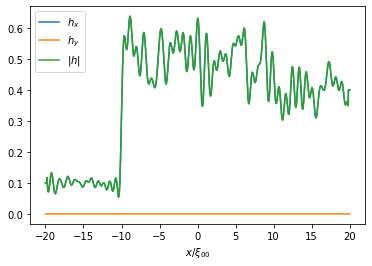

In [104]:
fig, ax = plt.subplots()
# ax.hlines([h_c0, -h_c0], -6, 6, colors="k", linestyles="--", linewidth=1)
ax.plot(x / xi_00, h_x, "-", label=r"$h_x$")
ax.plot(x / xi_00, h_y, "-", label=r"$h_y$")
ax.plot(x / xi_00, np.sqrt(h_x**2 + h_y**2), "-", label=r"$|h|$")
ax.set_xlabel(r"$x / \xi_{00}$")
ax.legend()

## Gap equation solver

In [105]:
# up.solve_self_consistent(verbose=True)

In [106]:
cc_idx = np.argsort(np.abs(np.abs(h_x) - h_c0))

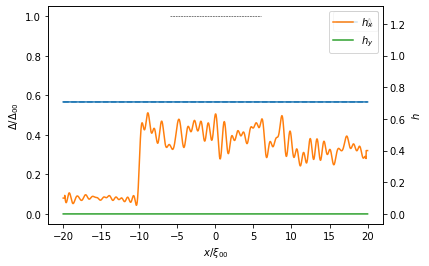

In [107]:
fig, ax = plt.subplots()
ax.plot(x / xi_00, up.Delta / Delta_00, "-C0", label=r"$\Delta$")
ax.set_ylabel(r"$\Delta / \Delta_{00}$")
# ax.vlines(x[cc_idx[0]] / xi_00, 0, 1, colors="k", linestyles="--", linewidth=0.5)
# ax.vlines([x[cc_idx[1]]/xi_00], 0, 1, colors="-k", linestyles="--", linewidth=1)
ax.plot(
    x / xi_00,
    up.Delta[Nx // 2 + 10] / Delta_00
    + (np.diff(up.Delta / Delta_00) / (x[1] - x[0]))[Nx // 2 + 10]
    * (x - x[Nx // 2 + 10]),
    "C0--",
)

ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$x/\xi_{00}$")

ax2 = ax.twinx()
ax2.hlines([+h_c0], -6, 6, colors="k", linestyles="--", linewidth=0.5)
# ax2.hlines([-h_c], -6, 6, colors="k", linestyles="--", linewidth=1)

ax2.plot(x / xi_00, h_x, "-C1", label=r"$h_x$")
ax2.plot(x / xi_00, h_y, "-C2", label=r"$h_y$")
ax2.set_ylabel(r"$h$")

ax.legend()
ax2.legend()

## Spectrum solver

In [125]:
omega_N = 301
up.set_real_omega_ax(-3, 3, omega_N)
up.solve_spectral(gamma=0.5, max_iter=2000, tol=1e-4, print_exit_status=True)

omega=3.00 : converged.
omega=2.98 : converged.
omega=2.96 : converged.
omega=2.94 : converged.
omega=2.92 : converged.
omega=2.90 : converged.
omega=2.88 : converged.
omega=2.86 : converged.
omega=2.84 : converged.
omega=2.82 : converged.
omega=2.80 : converged.
omega=2.78 : converged.
omega=2.76 : converged.
omega=2.74 : converged.
omega=2.72 : converged.
omega=2.70 : converged.
omega=2.68 : converged.
omega=2.66 : converged.
omega=2.64 : converged.
omega=2.62 : converged.
omega=2.60 : converged.
omega=2.58 : converged.
omega=2.56 : converged.
omega=2.54 : converged.
omega=2.52 : converged.
omega=2.50 : converged.
omega=2.48 : converged.
omega=2.46 : converged.
omega=2.44 : converged.
omega=2.42 : converged.
omega=2.40 : converged.
omega=2.38 : converged.
omega=2.36 : converged.
omega=2.34 : converged.
omega=2.32 : converged.
omega=2.30 : converged.
omega=2.28 : converged.
omega=2.26 : converged.
omega=2.24 : converged.
omega=2.22 : converged.
omega=2.20 : converged.
omega=2.18 : con

In [126]:
omega_ax = up.get_omega_ax_r()
DOS = up.get_dos()
DOSu, DOSd = up.get_spin_resolved_dos("x")

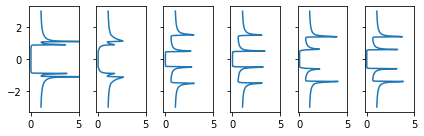

In [127]:
fig, ax = plt.subplots(ncols=6, figsize=(6, 2), sharey=True)

ax[0].plot(
    DOS[:, Nx // 5 * 0 + 10],
    omega_ax,
)
ax[1].plot(
    DOS[:, Nx // 5 * 1],
    omega_ax,
)
ax[2].plot(
    DOS[:, Nx // 5 * 2],
    omega_ax,
)
ax[3].plot(
    DOS[:, Nx // 5 * 3],
    omega_ax,
)

ax[4].plot(
    DOS[:, Nx // 5 * 4],
    omega_ax,
)

ax[5].plot(
    DOS[:, -1],
    omega_ax,
)

for sax in ax:
    sax.set_xlim(-0.2, 5)


fig.tight_layout()

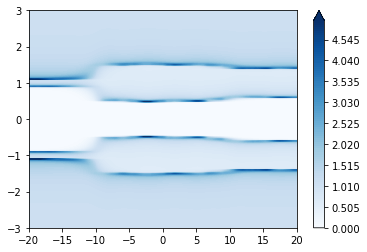

In [128]:
im = plt.contourf(
    x, omega_ax, DOS, extend="max", levels=np.linspace(0, 5, 100), cmap="Blues"
)
plt.colorbar(im)

In [129]:
# h_N = 101
# h_ax = np.linspace(0, 1, h_N)
# sf_N = 21
# sf_ax = np.linspace(0, 0.2, sf_N)

# dos_h = np.zeros((h_N, sf_N, omega_N))

# for i,j in tqdm(np.ndindex(h_N, sf_N), total=h_N*sf_N):

#     up_test = UsadelProblem(
#         Nsites=1,
#         diff_ops=trivial_diffops(),
#         h_x=np.array([0.0]) + h_ax[i],
#         h_y=np.array([0.0]),
#         h_z=np.array([0.0]),
#         tau_sf_inv=np.array([0.0]) + sf_ax[j],
#         tau_so_inv=np.array([0.0]),
#         D=0,
#         T=T,
#         Gamma=Gamma,
#     )

#     up_test.Delta = np.array([1.0])

#     up_test.set_real_omega_ax(-3, 3, omega_N)
#     up_test.solve_spectral()

#     dos_h[i, j] = up_test.get_dos()[:, 0]

# np.save("h_ax.npy", h_ax)
# np.save("sf_ax.npy", sf_ax)
# np.save("dos_h.npy", dos_h)

In [130]:
h_ax = np.load("h_ax.npy")
sf_ax = np.load("sf_ax.npy")
dos_h = np.load("dos_h.npy")

h_N = len(h_ax)
sf_N = len(sf_ax)

In [131]:
dos_h_red = dos_h[:, :, :]

h_eff_idx = np.zeros((Nx), dtype=int)
sf_eff_idx = np.zeros((Nx), dtype=int)
ls = np.zeros((Nx), dtype=float)

for i in tqdm(range(Nx)):
    squares = np.sum((dos_h_red - DOS[:, i]) ** 2, axis=-1)
    ls[i] = np.min(squares) * dx
    h_eff_idx[i], sf_eff_idx[i] = np.unravel_index(
        np.argmin(squares), dos_h_red.shape[0:2]
    )

h_eff = h_ax[h_eff_idx]
sf_eff = sf_ax[sf_eff_idx]

  0%|          | 0/2001 [00:00<?, ?it/s]

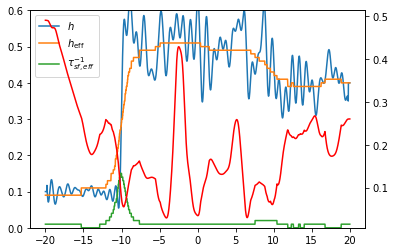

In [132]:
fig, ax = plt.subplots()
ax.plot(x / xi_00, h_x, label=r"$h$")
ax.plot(x / xi_00, h_eff, label=r"$h_\mathrm{eff}$")
ax.plot(x / xi_00, sf_eff, label=r"$\tau_{sf, eff}^{-1}$")

ax2 = ax.twinx()
ax2.plot(x / xi_00, ls, "r")

# plt.plot(x/xi_00, np.exp(-(x/xi_00+2)**2)*0.5, label="gaussian")
# plt.plot(x/xi_00, np.exp(-np.abs(x/xi_00+1.5))*0.5, label="exponential")
ax.set_ylim(0, 0.6)
ax.legend()

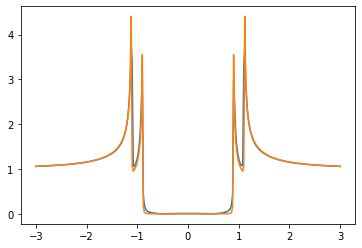

In [133]:
idx = 250  # Nx//2
plt.plot(omega_ax, DOS[:, idx])
plt.plot(omega_ax, dos_h[h_eff_idx[idx], sf_eff_idx[idx]])

In [134]:
# import scipy as sp
# from scipy.fft import fft, fftshift, ifft, ifftshift
# from scipy.optimize import minimize

# def estimate_kernel(x_in, y_out, k_0):

#     def fun(k, x):
#         res = np.sum((np.convolve(x, k, mode='same') - y_out)**2)
#         return res

#     return minimize(fun, k_0, args=x_in)

In [135]:
def sgnd(x, alpha, beta):
    return (
        beta
        / (2 * alpha * sp.special.gamma(1 / beta))
        * np.exp(-((abs(x) / alpha) ** beta))
    )


def estimate_kernel(h, h_eff, p0):
    def fun(params):
        alpha, beta = params
        # beta = params
        return np.sum(
            (convolve(h, sgnd(x, xi_00, beta) * dx, mode="nearest") - h_eff) ** 2
        )

    return minimize(fun, p0, bounds=((1e-3, None), (1e-3, None)))

    # return minimize(fun, p0)#, bounds=((None), (None)))

In [136]:
out = estimate_kernel(h_x, h_eff, (xi_00, 1))
out

      fun: 0.33764583042335794
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 1.78745906e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([1.00008497, 0.87021194])

In [138]:
# without sf 0.35747495
# with sf 0.712

In [139]:
kernel = sgnd(x, *(out.x))
# kernel = sgnd(x, np.sqrt(2)/2, 2)

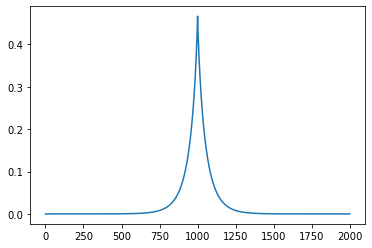

In [140]:
plt.plot(kernel)
kernel = sgnd(x, 1, 1)
# plt.plot(kernel)

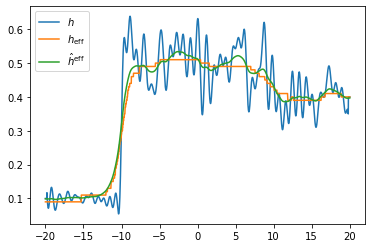

In [141]:
fig, ax = plt.subplots()
plt.plot(x / xi_00, h_x, label=r"$h$")
plt.plot(x / xi_00, h_eff, label=r"$h_\mathrm{eff}$")
plt.plot(
    x / xi_00,
    convolve(h_x, kernel, mode="nearest") * dx,
    label=r"$\hat{h}^\mathrm{eff}$",
)
# plt.ylim(0, 0.6)
ax.legend()